In [1]:
!pip install -Uq diffusers transformers fastcore

In [2]:
import math
from diffusers import StableDiffusionImg2ImgPipeline
from fastdownload import FastDownload
from IPython.display import display
from transformers import CLIPTextModel, CLIPTokenizer
import  torch
from diffusers import LMSDiscreteScheduler
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from PIL import Image
logging.disable(logging.WARNING)
torch.manual_seed(1)

from tqdm.auto import tqdm
from diffusers import AutoencoderKL, UNet2DConditionModel
import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()
clear_gpu()
from torchvision import transforms as tfms
from scipy.ndimage import uniform_filter
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Components for tokenizing, creating embeddings, the autoencoder, and the denoising model all used in the latent diffusion loop

In [3]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype=torch.float16)
text_encoder=CLIPTextModel.from_pretrained(
    'openai/clip-vit-large-patch14',
    torch_dtype=torch.float16).to('cuda')

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-ema",
    torch_dtype=torch.float16
).to('cuda')

unet=UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4',
    subfolder='unet',
    torch_dtype=torch.float16
).to('cuda')

Some utility functions for encoding, decoding, and viewing images and latent representations of images

In [4]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        t=tfms.ToTensor()(input_im).unsqueeze(0).to('cuda').half()*2-1
        if (t.shape[1] == 4):
            t=t[:,:-1]
        latent = vae.encode(t) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def show_latents(latents):
    if len(latents) == 64:
        plt.imshow(latents.cpu(),cmap='gray')
        plt.show()
        
    else:
        fig,axes=plt.subplots(1,4,figsize=(32,8))
        for i in range(4):
            with torch.no_grad():
                axes[i].imshow(latents[0][i].cpu(),cmap='gray')


Open up some images to experiment with

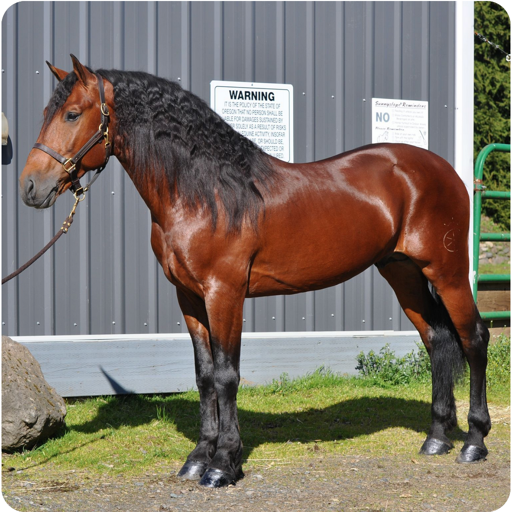

In [5]:
horse1 = Image.open('./imgs/horse1.png')
horse1=horse1.resize((512,512))
horse2 = Image.open('./imgs/horse2.png')
horse2=horse2.resize((512,512))
panda = Image.open('./imgs/panda guitar.jpg').resize((512,512))

horse1

# Making a pipeline

Noise scheduler: how much noise should be present at each step of denoising

In [6]:
beta_start,beta_end=0.00085,0.012
scheduler=LMSDiscreteScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000)

A callback for debugging purposes to view where the latents are at (where they're going wrong!) at each point in loop

In [7]:
def display_latents(i, generated_latent, renoised_latent):
    if i % 10 == 0:
        display(latents_to_pil(generated_latent)[0])
        display(latents_to_pil(renoised_latent)[0])

The main implementation of the plain latent diffusion loop: encode the prompt and the unconditional embedding, iteratively denoise a random latent, and scale it away from the unconditional embedding towards the prompt. However this implementation includes support for:
 - An initial image to start the diffusion process based on an early, partially noised version of its latent
 - Negative prompts (replacing the unconditional embedding which would normally be the embedding of empty text with the embedding of the negative prompt, since the 'guidance' algebra works out the same either way to assign negative weight to the denoised latent resulting from  this embedding)
 - A callback to do something with the latent at each iteration
 - Cosine decay of the guidance scale in order to provide high guidance at the beginning of the generation process, and little-to-no guidance near the end of the process by which time the denoised latent should have already assumed the essential characteristics of the prompt. Similar to cosine decay of learning rate.

used like this:

In [8]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(image_tensor):
    image = (image_tensor/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

def mk_samples(prompt, g=7.5, seed=100, steps=70, init_im=None, neg_prompt=None, cb=None, cos=False):
    text = text_enc([prompt])
    
    if neg_prompt is None:
        uncond = text_enc([""])
    else:
        uncond = text_enc([neg_prompt])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    noise = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half() 
    scheduler.set_timesteps(steps)
    
    if init_im is None:
        latents = noise* scheduler.init_noise_sigma
        start_step=0
    else:
        start_step=steps//5
        init_latent=pil_to_latent(init_im)
        print(init_latent.shape, noise.shape)
        latents=scheduler.add_noise(init_latent, noise, torch.tensor([scheduler.timesteps[start_step]]))
                                    
    scaled_g=torch.cos(torch.range(0., math.pi, (math.pi)/steps))
    scaled_g=((scaled_g+1)*(g/2))
    # print(scaled_g)
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        if i >= start_step:
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

            if cos:
                pred = u + scaled_g[i]*(t-u)
            else:
                pred = u + g*(t-u)
            latents = scheduler.step(pred, ts, latents).prev_sample
            if cb is not None:
                cb(i, latents)

    '''
    returns decoded latent, i.e. the tensor representation of a full Image.
    '''
    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample.squeeze()


In [9]:
def stats(t):
    print(f"min {t.min()} max {t.max()} med {t.median()} mean {t.mean()}")

Returns a mask, a tensor of 1s and 0s representing pixels of the latent showing which pixels need to be changed in order
to accomplish the desired semantic edit.

Example, given an image of a horse, a reference="a horse" and query="a zebra", the horse should be covered by the
mask (it's what needs to change) but the background, sky, grass, trees etc should not primarily be covered: they
should stay the same so that the result is an *edited* version of the original image and not a *completely*
different image.

Still includes some helpful debugging logs to output stats during the generation process

Broken out implementation to show the intermediate states of the DiffEdit process

In [10]:
def generate_mask(
    reference,      # Text description: what *is* the initial image? 
    query,          # Text description: what *do you want* the image to be?
    im,             # The initial image
    debug=True,
    steps=70
):

    query_emb = text_enc([query])
    ref_emb = text_enc([reference])

    emb = torch.cat([query_emb, ref_emb])

    noise = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half() 
    scheduler.set_timesteps(steps)

    start_step=steps - (steps//2)
    init_latent=pil_to_latent(im)
    start_ts=torch.tensor([scheduler.timesteps[start_step]]).to('cuda')
    latents=scheduler.add_noise(init_latent, noise, start_ts)
    #latents = init_latent + noise/2

    inp = scheduler.scale_model_input(torch.cat([latents] * 2), start_ts)
    with torch.no_grad(): q,r = unet(inp, start_ts, encoder_hidden_states=emb).sample.chunk(2)

    #thank you for the math - https://github.com/Xiang-cd/DiffEdit-stable-diffusion/blob/main/diffedit.ipynb
    diffabs=(q-r).abs_()
    if debug:
        print('diffabs')
        stats(diffabs)
        show_latents(diffabs)

    diffabsmean = diffabs.mean(dim=[0,1])
    max_v = diffabsmean.mean() * 3
    if debug:
        print(f'max_v {max_v}')
    mask = diffabsmean.clamp(0, max_v) / max_v
    if debug:
        print('mask unbinarized')
        stats(mask)
        show_latents(mask)

    blurred=torch.tensor(uniform_filter(mask.float().cpu(),size=10)).to('cuda')
    if debug:
        stats(blurred)
        show_latents(blurred)

    maskb=(blurred>.25).half()
    if debug:
        print('mask binarized')
        show_latents(maskb)
    return maskb

Thanks for sticking through all that. Now lets make a new function where we modify the latent diffusion algorithm to receive the mask we described earlier, and do the DiffEdit inside the loop: 
 - Start the loop with a partially noised version of the initial image latent
 - At each step, paste in the original latent *outside* of the mask (after noising it according to the current iteration in the schedule)
 - ... while keeping the interior of the mask the same. This is done in the mask algebra of `latents * mask + renoised_init*(1-mask)`
 - Still includes callbacks and cosine guidance scale decay like the regular latent diffusion function above
 - Includes tunable argument for "how early" the original image should be noised to start the process
     - start_ratio = 0: the inside of the mask doesn't get any opportunity to be influenced by the original image and will struggle to blend in with background.
     - start_ratio = 1: no editing happens, we 'start all the way at the end (of the noise scheduler)' and don't give any chance for generating anything inside the mask that deviates from original image.

In [11]:
def mk_sample_w_mask(prompt, mask, init_im, g=7.5, seed=100, steps=70, neg_prompt=None, cb=None, cos=False, start_ratio=.7):
    text = text_enc([prompt])
    mask=mask.to('cuda')

    if neg_prompt is None:
        uncond = text_enc([""])
    else:
        uncond = text_enc([neg_prompt])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    noise = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half()
    scheduler.set_timesteps(steps)

    if init_im is None:
        raise 'oops'
    else:
        start_step=math.floor(steps * start_ratio)
        init_latent=pil_to_latent(init_im)
        latents=scheduler.add_noise(init_latent, noise, torch.tensor([scheduler.timesteps[start_step]]))
    
    scaled_g=torch.cos(torch.range(0., math.pi, (math.pi)/steps))
    scaled_g=((scaled_g+1)*(g/2))
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        if i >= start_step:
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

            if cos:
                pred = u + scaled_g[i]*(t-u)
            else:
                pred = u + g*(t-u)
            latents = scheduler.step(pred, ts, latents).prev_sample
            renoised_init = scheduler.add_noise(init_latent, noise, ts.unsqueeze(0))
            masked = latents * mask + renoised_init*(1-mask)
            if cb is not None:
                cb(i, latents, renoised_init)
            latents=masked

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample.squeeze()


Just a little callback: save the generated latents along the way, we'll make a gif of them later to show how the algorithm progresses.

In [12]:
latentlist=[]
def savelatent(i, latents, _):
    latentlist.append(latents)

Now just wrap everything up into one function to do it all.

In [13]:
def diffedit(sourcetext, querytext, im, cos=False, g=15, start_ratio=.2, steps=100):
    mask=generate_mask(sourcetext, querytext, im, debug=False)
    sample=mk_sample_w_mask(querytext, mask, im, cos=cos, g=g, start_ratio=start_ratio,steps=steps, cb=savelatent)
    return mk_img(sample)

# Try It Out!

Edit the original description, target description, and original image in the top of this cell, then run it to see:
 - The output DiffEdited image
 - The original image (as a reminder of the starting point)
 - A gif of the progress

/tmp/ipykernel_1093/3791754202.py:14: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  noise = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half()
/tmp/ipykernel_1093/4252956112.py:12: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  noise = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half()
/tmp/ipykernel_1093/4252956112.py:22: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  scaled_g=torch.cos(torch.range(0., math.pi, (math.pi)/steps

  0%|          | 0/100 [00:00<?, ?it/s]

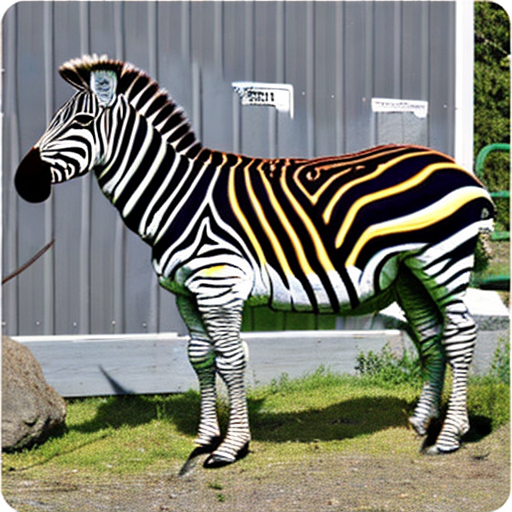

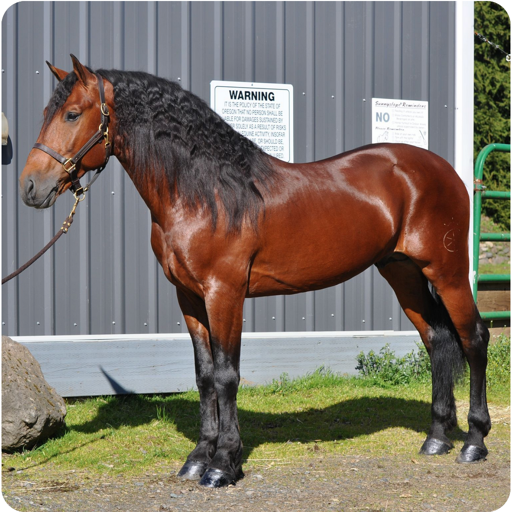

In [14]:
original_desc = 'a horse in front of a metal wall'
target_desc = 'a zebra in front of a wall'
image=horse1
# or else:
# image = Image.open('local/path/or.url').resize((512,512)) 

latentlist=[] # reset saved latent list to make gif out of
display(diffedit(original_desc, target_desc, image, g=10, steps=100))

'''
Just to remember what the original looked like
'''

display(image)

'''
...and show all those intermediate steps as a gif
'''

fig,ax = plt.subplots()
nframes=30
length = len(latentlist)
def one_frame(fnum):
    idx=length - (nframes-fnum) * length//nframes
    ax.clear()
    ax.imshow(latents_to_pil(latentlist[idx])[0])

ani=FuncAnimation(fig, one_frame, frames=nframes, interval=200,repeat=True)

plt.close()
HTML(ani.to_jshtml())